In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K

2025-06-02 22:31:15.770942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748903476.022282      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748903476.089825      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/train"
test_dir = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/test"
val_dir = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/val"

In [3]:
img_size = 224
batch_size = 32

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    color_mode="rgb",
    seed=42
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False,
    color_mode="rgb",
    seed=42
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False,
    color_mode="rgb",
    seed=42
)

class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")


rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

def apply_rescaling(images, labels):
    return rescale(images), labels

train_dataset = train_dataset.map(apply_rescaling, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(apply_rescaling, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(apply_rescaling, num_parallel_calls=AUTOTUNE)


train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(AUTOTUNE)

Found 11923 files belonging to 34 classes.


I0000 00:00:1748903500.936536      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748903500.937274      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2544 files belonging to 34 classes.
Found 2585 files belonging to 34 classes.
Number of classes: 34


In [5]:
def inverted_residual_block(x_in, filters_out, strides=1, expansion_factor=4, use_attention=True, dropout_rate=0.0):
    shortcut = x_in
    filters_in = K.int_shape(x_in)[-1]
    
    if expansion_factor > 1:
        expanded_channels = filters_in * expansion_factor
        x = Conv2D(expanded_channels, 1, padding='same', use_bias=False, 
                  kernel_initializer='he_normal')(x_in)
        x = BatchNormalization()(x)
        x = Activation('relu6')(x)
    else:
        x = x_in
    
    x = DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False, depthwise_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)
    
    if use_attention and filters_out >= 64:
        x = efficient_channel_attention(x, ratio=8)
    
    x = Conv2D(filters_out, 1, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    
    if strides == 1 and filters_in == filters_out:
        x = Add()([shortcut, x])
    
    return x

def create_flora_net_lite(input_shape, num_classes, width_multiplier=0.75):
    inputs = Input(shape=input_shape)
    x = inputs
    
    def make_divisible(v, divisor=8):
        new_v = max(divisor, int(v + divisor / 2) // divisor * divisor)
        if new_v < 0.9 * v:
            new_v += divisor
        return new_v
    
    filters = make_divisible(16 * width_multiplier)
    x = Conv2D(filters, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)
    
    stage_configs = [
        (24, 2, 2, False),
        (32, 3, 2, False),
        (64, 4, 2, True),
        (96, 6, 1, True),
    ]
    
    for filters, expansion, stride, use_attention in stage_configs:
        filters = make_divisible(filters * width_multiplier)
        x = inverted_residual_block(x, filters, strides=stride, expansion_factor=expansion, use_attention=use_attention, dropout_rate=0.1)
        x = inverted_residual_block(x, filters, strides=1, expansion_factor=expansion, use_attention=use_attention)
    
    final_filters = make_divisible(320 * width_multiplier)
    x = Conv2D(final_filters, 1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='FloraNetLite')
    return model

In [6]:
input_shape = (img_size, img_size, 3)
model = create_flora_net_lite(input_shape, num_classes, width_multiplier=0.5)

In [7]:
def get_callbacks(model_name):
    return [
        ModelCheckpoint(
            f'/kaggle/working/best_loss_{model_name}.keras', 
            monitor='val_loss', 
            save_best_only=True, 
            mode='min', 
            verbose=1
        ),
        ModelCheckpoint(
            f'/kaggle/working/best_accuracy_{model_name}.keras', 
            monitor='val_accuracy', 
            save_best_only=True, 
            mode='max',
            verbose=1
        ),
        ModelCheckpoint(
            f'/kaggle/working/best_model_loss_{model_name}.keras', 
            monitor='loss', 
            save_best_only=True, 
            mode='min',
            verbose=1
        ),
        EarlyStopping(
            monitor='loss',
            patience=25,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=10,
            min_lr=1e-8,
            verbose=1
        )
    ]

In [8]:
print("\nFloraNet Summary:")
callbacks = get_callbacks("FloraNet")
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.8, nesterov=True), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


FloraNet Summary:


Model: "FloraNetLite"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 8)    │            216 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 8)    │             32 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 8)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 16)   │            128 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 56, 56, 16)     │            144 │ activation_1[0][0]     │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 16)     │             64 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 16)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 16)     │            256 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 56, 56, 16)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 32)     │            512 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 56, 56, 32)     │              0 │ batch_normalization_4… │
├──────────────────────

 Total params: 87,562 (342.04 KB)

 Trainable params: 83,514 (326.23 KB)

 Non-trainable params: 4,048 (15.81 KB)

In [9]:
history = model.fit(train_dataset, epochs=300, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/300


I0000 00:00:1748903519.786870      66 service.cc:148] XLA service 0x7f0a2010f460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748903519.787667      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748903519.787691      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748903520.895960      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/373 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.0226 - loss: 3.7939   

I0000 00:00:1748903534.881174      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1883 - loss: 2.8745
Epoch 1: val_loss improved from inf to 4.41985, saving model to /kaggle/working/best_loss_FloraNet.keras

Epoch 1: val_accuracy improved from -inf to 0.02555, saving model to /kaggle/working/best_accuracy_FloraNet.keras

Epoch 1: loss improved from inf to 2.35227, saving model to /kaggle/working/best_model_loss_FloraNet.keras
373/373 ━━━━━━━━━━━━━━━━━━━━ 78s 136ms/step - accuracy: 0.1886 - loss: 2.8731 - val_accuracy: 0.0256 - val_loss: 4.4198 - learning_rate: 0.0100
Epoch 2/300
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5004 - loss: 1.6014
Epoch 2: val_loss improved from 4.41985 to 2.59106, saving model to /kaggle/working/best_loss_FloraNet.keras

Epoch 2: val_accuracy improved from 0.02555 to 0.30857, saving model to /kaggle/working/best_accuracy_FloraNet.keras

Epoch 2: loss improved from 2.35227 to 1.48347, saving model to /kaggle/working/best_model_loss_FloraNet.keras
373/373 ━━━━━━━━━━━━━━━━━

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

def evaluate_model(model, history, name, test_dataset):
    print(f"\nEvaluating {name}...")
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test accuracy: {test_acc:.4f}")
    
    y_pred_prob = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_prob, axis=1)
    

    y_true = []
    for images, labels in test_dataset.unbatch():
        if len(labels.shape) > 0 and labels.shape[0] > 1:
            y_true.append(tf.argmax(labels).numpy())
        else:
            y_true.append(int(labels.numpy()))
    
    y_true = np.array(y_true[:len(y_pred)])
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=True)
    plt.title(f"Confusion Matrix - {name}", fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/confusion_matrix_{name.replace(" ", "_")}.png')
    plt.close()
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='darkorange', label='Training')
    plt.plot(history.history['val_loss'], color='blue', label='Validation')
    plt.title(f'Loss vs Epochs - {name}', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color='darkorange', label='Training')
    plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
    plt.title(f'Accuracy vs Epochs - {name}', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/training_history_{name.replace(" ", "_")}.png')
    plt.close()
    
    return accuracy, y_true, y_pred, y_pred_prob

In [11]:
acc1, y_true1, y_pred1, y_pred_prob1 = evaluate_model(model, history, "FloraNet", test_dataset)


Evaluating FloraNet...
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9801 - loss: 0.0700
Test accuracy: 0.9764
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
Accuracy: 0.9764
Precision: 0.9769
Recall: 0.9764
F1 Score: 0.9764

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        75
           1       0.96      1.00      0.98        75
           2       0.99      0.91      0.94        75
           3       0.96      0.99      0.97        77
           4       0.99      1.00      0.99        77
           5       1.00      0.99      0.99        77
           6       0.95      0.99      0.97        75
           7       1.00      1.00      1.00        77
           8       0.91      0.97      0.94        75
           9       1.00      0.97      0.99        77
          10       0.94      1.00      0.97        77
          11       1.00      0.96      0.98        77
          12       1.00      0.95      0.97   

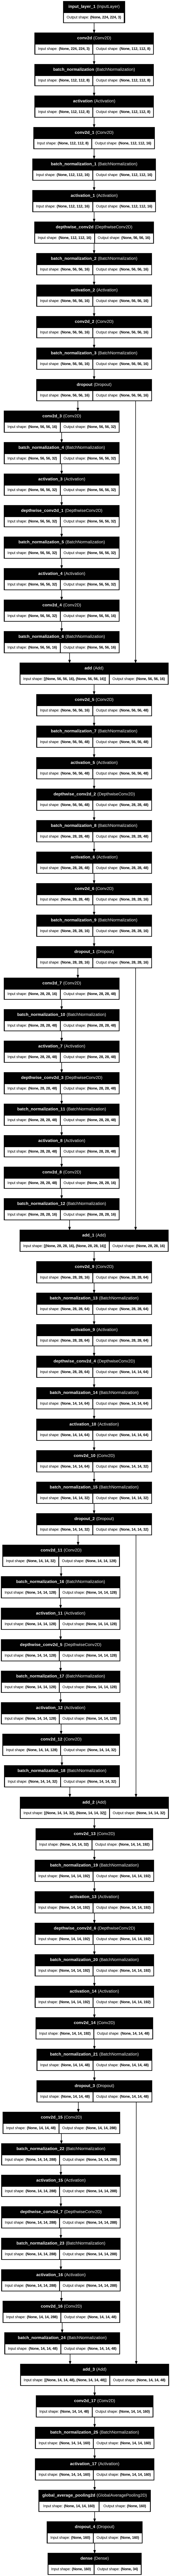

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

<Axes: >

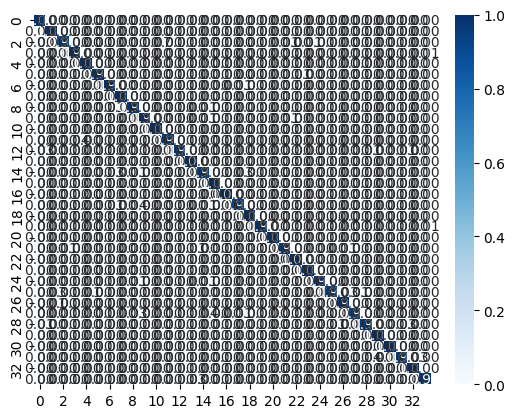

In [13]:
cm = confusion_matrix(y_true1, y_pred1, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f")


In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels
y_true_bin = label_binarize(y_true1, classes=list(range(num_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 10))
colors = cycle(plt.cm.tab20.colors)

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/roc_curve_multiclass.png')
plt.close()

In [15]:
pip install lime --quiet


Note: you may need to restart the kernel to use updated packages.


In [16]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

explainer = lime_image.LimeImageExplainer()

# Pick a sample image from the test dataset
for image_batch, label_batch in test_dataset.take(1):
    idx = random.randint(0, batch_size - 1)
    image = image_batch[idx].numpy()
    label = label_batch[idx].numpy()
    break

# Explaining prediction
explanation = explainer.explain_instance(
    image.astype('double'),
    classifier_fn=lambda x: model.predict(tf.convert_to_tensor(x)),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("/kaggle/working/lime_explanation.png")
plt.close()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

In [17]:
import os
import pandas as pd
from collections import Counter

def get_class_distribution(directory):
    return Counter([folder for folder in os.listdir(directory) 
                    if os.path.isdir(os.path.join(directory, folder))])

train_dist = get_class_distribution(train_dir)
df = pd.DataFrame.from_dict(train_dist, orient='index', columns=['count'])

df.plot(kind='barh', figsize=(10, 8), color='green')
plt.title("Class Distribution - Train Set", fontsize=14)
plt.xlabel("Image Count")
plt.tight_layout()
plt.savefig("/kaggle/working/class_distribution_train.png")
plt.close()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


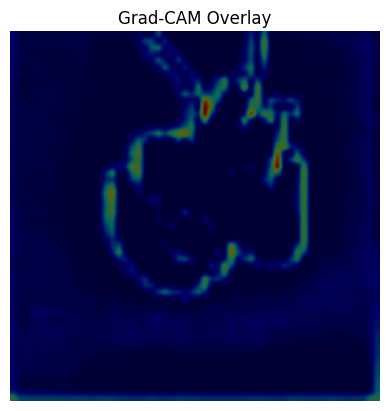

In [18]:
import cv2
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Select sample image from test set
for image, label in test_dataset.unbatch().take(1):
    img = tf.expand_dims(image, axis=0)
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name='conv2d_5')  # Update to your last conv layer name

    heatmap = cv2.resize(heatmap, (img_size, img_size))
    heatmap_colored = cm.jet(heatmap)[:, :, :3]
    overlay = heatmap_colored * 0.4 + image.numpy() / 255.0
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.savefig('/kaggle/working/gradcam.png')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

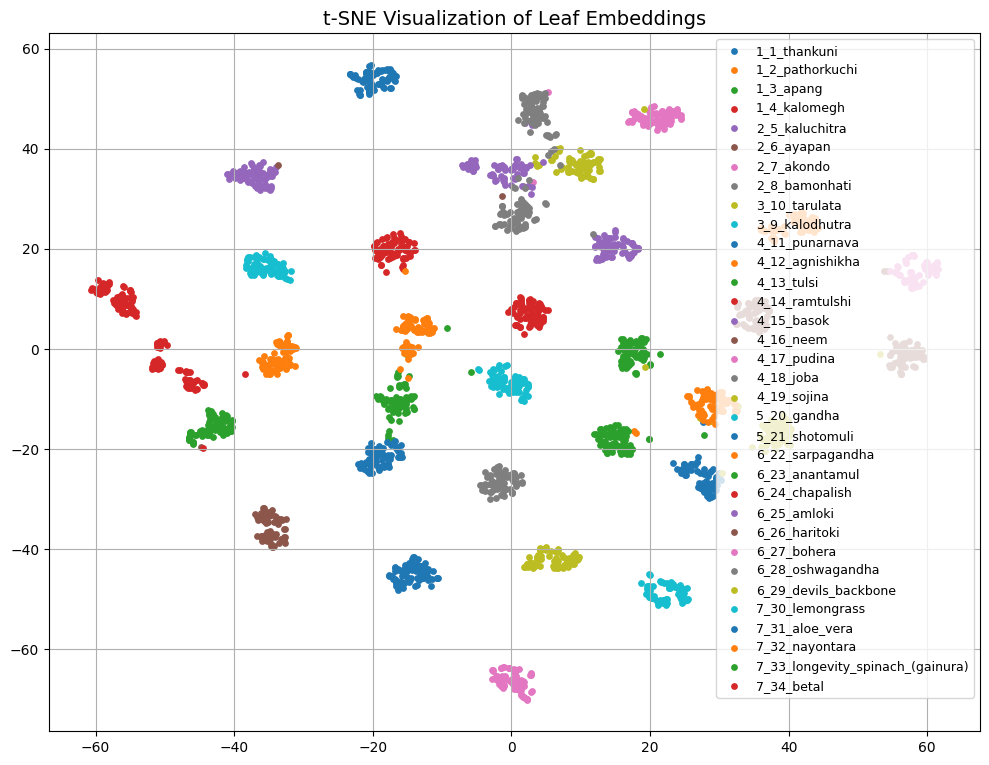

In [19]:
from sklearn.manifold import TSNE

features = []
labels = []

feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)

for images, lbls in test_dataset:
    feats = feature_extractor.predict(images)
    features.append(feats)
    labels.extend(tf.argmax(lbls, axis=1).numpy())

features = np.concatenate(features, axis=0)
labels = np.array(labels)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    idxs = labels == i
    plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=class_names[i], s=15)
plt.legend(fontsize=9)
plt.title("t-SNE Visualization of Leaf Embeddings", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/tsne_plot.png')
plt.show()


# Save Model for future

In [20]:
model.save("/kaggle/working/medicinal_plant_classifier.h5")


In [21]:
from tensorflow.keras.models import load_model

# If saved as .h5
model = load_model("/kaggle/working/medicinal_plant_classifier.h5")

# Or if saved in TensorFlow SavedModel format
# model = load_model("/kaggle/working/medicinal_plant_classifier")
